### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib widget

In [2]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`

In [3]:
# For loading the CSV files
import csv
import pyproj

In [293]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy, 
                                   segment_indices, segment_indices_gap,
                                   subsample_tracks_uniform, 
                                  )

In [186]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [6]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

# Stanford/SPRI

It looks like Stanford contributed additional bed picks along some of the old SPRI lines, duplicating what shows up in BM1.

They also published the coordinates and ice thicknesses on a per-flight basis from the original dataset:
* Officially available from https://purl.stanford.edu/sq529nv6867 , but that's missing some data
* Better data is on github: https://github.com/radioglaciology/radarfilmstudio

In [150]:
orig_spri_path = "/Users/lindzey/RadarData/ANTARCTIC/STANFORD"
orig_spri_filepaths = [os.path.join(orig_spri_path, ff) for ff in os.listdir(orig_spri_path) 
                       if ff.endswith("csv") and not ff.startswith('.')]
spri_path = "/Users/lindzey/RadarData/ANTARCTIC/STANFORD/radarfilmstudio/antarctica_original_positioning"
spri_filepaths = [os.path.join(spri_path, ff) for ff in os.listdir(spri_path) 
                       if ff.endswith("csv") and not ff.startswith('.')]

In [151]:
print("We have {} flights from github, and {} from the original Stanford release".format(len(spri_filepaths), len(orig_spri_filepaths)))

We have 61 flights from github, and 54 from the original Stanford release


In [152]:
with open(spri_filepaths[0], 'r') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    print("Stanford's SPRI csv files have fields: {}".format(csv_reader.fieldnames))
    coords = [map(float, (elem['LAT'], elem['LON'])) for elem in csv_reader]

Stanford's SPRI csv files have fields: ['CBD', 'LAT', 'LON', 'THK', 'SRF']


In [153]:
import csv
import pyproj
def load_spri_xy(filepath):
    # Without specifying the encoding, most of the files have \ufeff in the first fieldname.
    with open(filepath, encoding='utf-8-sig') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        coords = [map(float, (elem['LAT'], elem['LON'])) for elem in csv_reader
                  if len(elem['LAT']) > 0]  # Some of the files end with lines of the form ",,,," 
          
    lat, lon = zip(*coords)
    ps71 = pyproj.Proj("epsg:3031")
    xx, yy = ps71.transform(lon, lat)
    return np.array(xx), np.array(yy)

In [155]:
spri_xx = {}
spri_yy = {}
for filepath in spri_filepaths:
    flight = pathlib.Path(filepath).stem
    spri_xx[flight], spri_yy[flight] = load_spri_xy(filepath)
orig_spri_xx = {}
orig_spri_yy = {}
for filepath in orig_spri_filepaths:
    flight = pathlib.Path(filepath).stem
    orig_spri_xx[flight], orig_spri_yy[flight] = load_spri_xy(filepath)

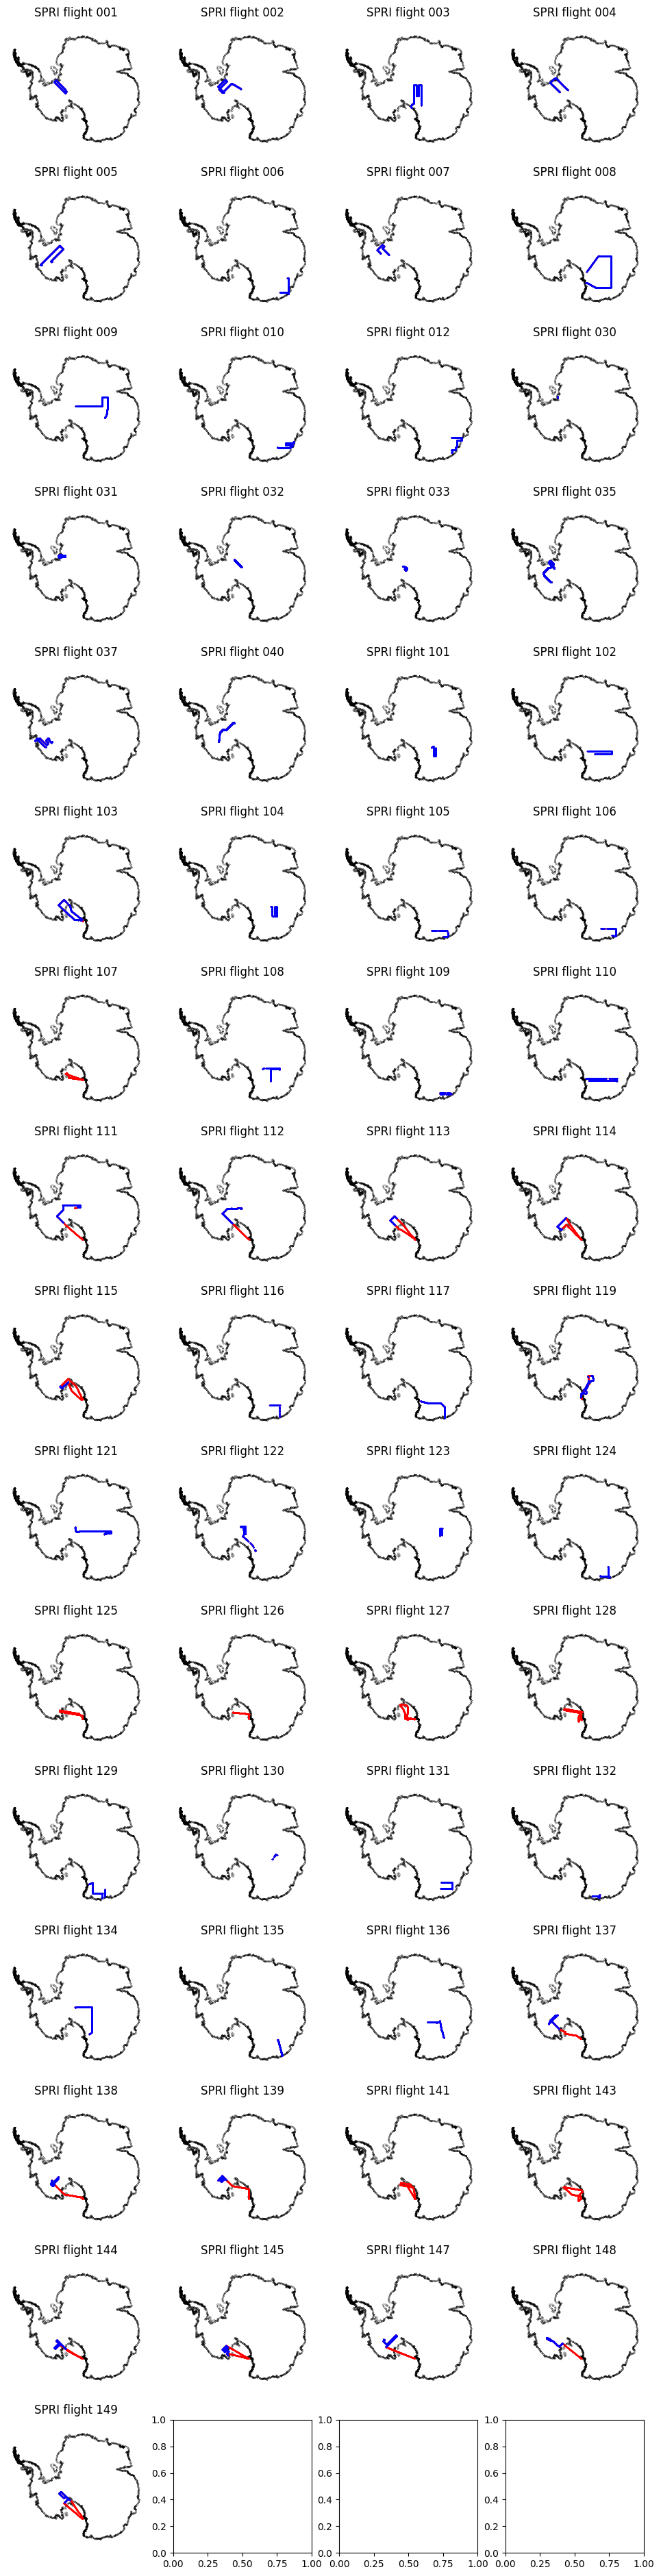

In [157]:
ncols = 4
nrows = int(np.ceil(len(spri_xx) / ncols))

fig = plt.figure(figsize=(3*ncols, 3*nrows))
axes = fig.subplots(nrows, ncols)

for idx, flight in enumerate(spri_xx.keys()):

    row = int(np.floor(idx / ncols))
    col = idx % ncols
    ax = axes[row][col]
    ax.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
    
    xx = spri_xx[flight]
    yy = spri_yy[flight]
    ax.plot(xx, yy, 'r.', markersize=0.5)
    
    if flight in orig_spri_xx:
        ax.plot(orig_spri_xx[flight], orig_spri_yy[flight], 'b.', markersize=0.5) 
    
    ax.set_title("SPRI flight {}".format(flight))
    ax.axis('equal')
    ax.axis('off')

Yup, the new data's flights agree and extend the previous ones.

However, there's still a bunch of flights that I think are missing their start/ends ... it seems like it was primarily the RIS crossings that Angelo was working with that got added. Transits in East Antarctica are largely missing.

### Now, try matching up to BEDMAP data

In [ ]:
# The SPRI surveys are so sparse that there's no need to decimate them before comparing.
spri_bm1_idxs = {}
for flight in spri_xx.keys():
    if flight in spri_bm1_idxs:
        continue
    spri_bm1_idxs[flight] = find_closest_bedmap(spri_xx[flight], spri_yy[flight], bm1_xx, bm1_yy)

In [160]:
all_idxs = np.array([])
for idxs in spri_bm1_idxs.values():
    all_idxs = np.append(all_idxs, idxs)

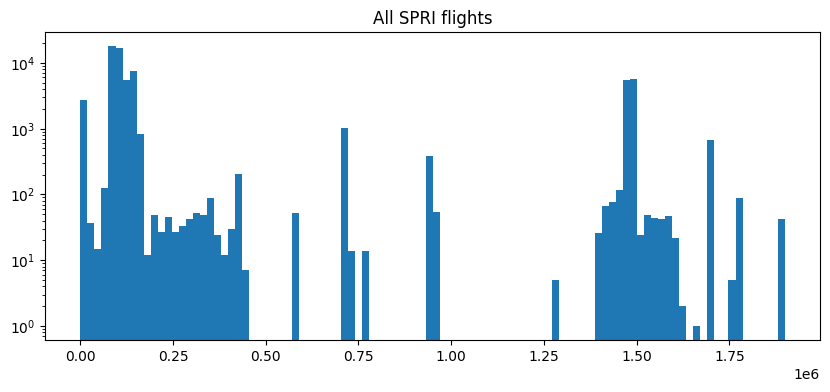

In [161]:
fig = plt.figure(figsize=(10,4))
ax = fig.subplots(1,1)
flight='001'
ax.hist(all_idxs, bins=100);
ax.set_title("All SPRI flights")
ax.set_yscale('log')
    
ax.vlines([], 0, 100, linestyle='dotted', colors='black')

In [ ]:
for flight, idxs in spri_bm1_idxs.items():
    print("flight {} has {} bm1 points (and {} orig points)".format(flight, len(idxs), len(spri_xx[flight])))

However, even though we have a closest point for each point in the SPRI dataset, I don't think those actually correspond to the correct points -- the SPRI nav data includes places where there are no ice thicknesses, which will correspond to gaps in the bedmap dataset.

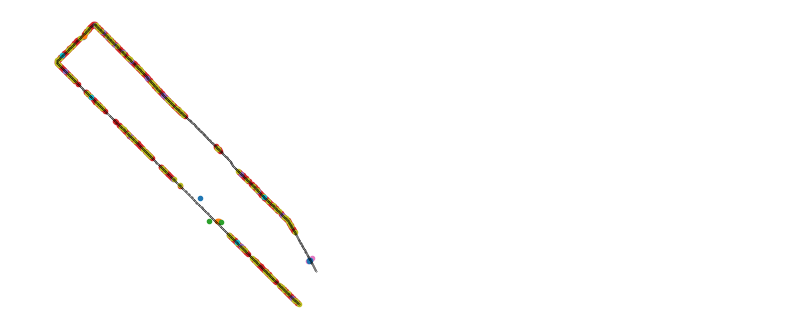

In [164]:
fig = plt.figure(figsize=(10,4))
ax1, ax2 = fig.subplots(1,2)
for ax in [ax1, ax2]:
    ax.axis('off')
    ax.axis('equal')
flight = '001'
idxs = list(set(spri_bm1_idxs[flight]))
idxs.sort()
flight_segments = segment_indices(idxs, 1, 1)  # Grab them ALL for now
for s0, s1 in flight_segments:
    ii = np.arange(s0, s1+1)
    ax1.plot(bm1_xx[ii], bm1_yy[ii], '.')
ax1.plot(spri_xx[flight], spri_yy[flight], 'k.', markersize=0.5)


## Give up and label by hand

I spent a while trying to do this automatically, but eventually decided that it would be faster to do it by hand, thanks to a lot of edge cases.

There are a lot of close overlaps (if I'm trying to get flight-by-flight right), as well as very fragmented representation of each flight in BM1 (minimum 3 segments, usually more) with points widely spaced.

In [415]:
# I had an issue where the extend_segment function had no bound on 
# how far successive points could jump, which ran into an issue on
# SPRI flight 114 where the next few points just happened to cross that flight.
# human_labels['114'].pop((85925, 85939))
# human_labels['114'].pop((85754, 86257))
# human_labels['114'].pop((85754, 85928))
# human_labels['114'].pop((85754, 85926))

# I also messed up a few times ...
# human_labels['005'][(1769723, 1769723)] = 'n'
# human_labels['005'][(1769765, 1769765)] = 'n'
# human_labels['005'][(1769834, 1769834)] = 'n'

# For some reason, this segment wasn't picked up. Easier to add it manually.
human_labels['114'][(103038, 103051)] = 'y'
human_labels['126'][(1482380, 1482381)] = 'y'

### Labeling all flights

In [ ]:
for flight in spri_xx.keys():
#for flight in ['141']:
    # Chunk the matching points into segments
    flight_idxs = spri_bm1_idxs[flight]
    
    # SPRI segments need to be split with a single non-matching point; there are
    # places in the dataset where there will be one outlier in the middle of
    # a stretch belonging to a single point
    max_step = 1
    
    # Go ahead and grab all of them, don't put a minimum length
    # Setting this to 1 is *painful*; 2 is a better tradeoff, 
    # though we probably miss the occasional point.
    min_length = 2
    
    # I'm not convinced that this is a good idea -- it was added to address
    # one issue, but then I'm getting a lot of isolated points that are 
    # sequentially in the same survey, just scattered
    max_gap = 25000
    if flight in ['114', '115']:
        flight_segments = segment_indices_gap(flight_idxs, max_step, min_length, bm1_xx, bm1_yy, max_gap)
    else:
        flight_segments = segment_indices(flight_idxs, max_step, min_length)
        
    xx = spri_xx[flight]
    yy = spri_yy[flight]
    
    for s0, s1 in flight_segments:
        if flight not in human_labels:
            human_labels[flight] = {}
            
        # If this segment has been labeled, continue.
        if (s0, s1) in human_labels[flight]:
            print("flight {} seg {}-{} exactly matches prev segment".format(flight, s0, s1))
            continue
        prev_y = []
        prev_n = []
        for (p0, p1), ll in human_labels[flight].items():
            if ll in ['y', 'x']:
                prev_y.extend(np.arange(p0, p1+1))
            elif ll in ['n', 'nx']:
                prev_n.extend(np.arange(p0, p1+1))
            else:
                print("unrecognized label {} for flight {} seg {}-{}".format(ll, flight, p0, p1))
        prev_y = np.array(list(set(prev_y)))
        prev_n = np.array(list(set(prev_n)))
        curr_s = np.arange(s0, s1+1)
        if len(np.setdiff1d(curr_s, prev_y)) == 0:
            print("seg {}-{} is part of flight {}".format(s0, s1, flight))
            continue
        elif len(np.setdiff1d(curr_s, prev_n)) == 0:
            print("seg {}-{} is NOT part of flight {}".format(s0, s1, flight))
            continue
                
        fig = plt.figure(figsize=(14,4))
        ax1, ax2, ax3 = fig.subplots(1,3)
        for ax in [ax1, ax2, ax3]:
            ax.axis('off')
            ax.axis('equal')
            ax.plot(xx, yy, 'k.', markersize=0.5)
        
        # Plot only points within the extracted segment
        segment_idxs = np.arange(s0, s1+1)
        seg_dists = [np.inf for _ in segment_idxs]
        for idx, ii in enumerate(segment_idxs):
            dx = xx-bm1_xx[ii]
            dy = yy-bm1_yy[ii]
            seg_dists[idx] = np.min(np.sqrt(dx*dx + dy*dy))
            
        ax1.scatter(bm1_xx[segment_idxs], bm1_yy[segment_idxs], c=segment_idxs)
        ax1.set_title("flight {}, {} - {}".format(flight, s0, s1))
        
        # Try expanding that segment as far as it matches input flight line
        radius = 10000
        expand_radius = 50000
        ex0, ex1 = expand_range(segment_idxs, xx, yy, bm1_xx, bm1_yy, radius, expand_radius)
        expanded_idxs = np.arange(ex0, ex1+1)
        ex_dists = [np.inf for _ in expanded_idxs]
        for idx, ii in enumerate(expanded_idxs):
            dx = xx-bm1_xx[ii]
            dy = yy-bm1_yy[ii]
            ex_dists[idx] = np.min(np.sqrt(dx*dx + dy*dy))

        ax2.scatter(bm1_xx[expanded_idxs], bm1_yy[expanded_idxs], c=expanded_idxs)
        ax2.set_title("Expanded: {} - {}".format(ex0, ex1))
        
        # Pad segment by fixed number of points for context
        pad = 10
        p0 = max(0, s0-pad)
        p1 = min(len(bm1_xx), s1+pad)
        padded_idxs = np.arange(p0, p1+1)
        ax3.scatter(bm1_xx[padded_idxs], bm1_yy[padded_idxs], c=padded_idxs)
        ax3.set_title("Padded: {} - {}".format(p0, p1))
        
        # For flight 147, it was very difficult to see whether points matched
        # in the tight part of the survey because it was zoomed out to fit the whole thing.
        # So, zoom in on the bedmap points in question.
        border = 25000
        xmin = np.min(bm1_xx[expanded_idxs]) - border
        xmax = np.max(bm1_xx[expanded_idxs]) + border
        ymin = np.min(bm1_yy[expanded_idxs]) - border
        ymax = np.max(bm1_yy[expanded_idxs]) + border
        for ax in [ax1, ax2]:
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
       
        plt.show()
        print("Min Segment dist: {:0.1f} km, max dist: {:0.1f} km".format(np.min(seg_dists)/1000, np.max(seg_dists)/1000))
        print("Min Expanded dist: {:0.1f} km, max dist: {:0.1f} km".format(np.min(ex_dists)/1000, np.max(ex_dists)/1000))
        
        # y "Yes" means keep the segment bounds
        # n "No" means reject segment bounds
        # x "eXtend" means keep the extended segment bounds
        # nx "None eXtended" means reject all points in the extended bounds
        # c "Continue" means don't label this segment now
        resp = input("Flight {}, {}-{}. Good? (y/n/x/nx)".format(flight, s0, s1))
        if resp == 'x':
            # We want to accept the full extended range
            human_labels[flight][(ex0, ex1)] = 'y'
        elif resp == 'nx':
            # Want to reject the full extended range
            human_labels[flight][(ex0, ex1)] = 'n'    
        elif resp == 'c':
            pass
        else:
            human_labels[flight][(s0, s1)] = resp


### Save human input

In [429]:
# Dictionary of dicts, mapping segment bounds to human labels for each flight
# human_labels = {flight: {} for flight in spri_xx.keys()}  #type Dict[str, Dict[Tuple(int, int), str]]
import pickle
pickle.dump(human_labels, open("spri_labels_v4.pkl", 'wb'))

### export segments in format suitable for extracting bedmap tracks

In [435]:
bm1_segments = segment_indices(spri_idxs, 1, 1)

In [436]:
bm1_segments

[(294, 294),
 (76619, 76714),
 (77019, 77518),
 (80598, 80620),
 (80709, 82775),
 (82793, 83454),
 (83469, 83711),
 (83715, 85370),
 (85382, 87543),
 (88178, 90279),
 (90286, 93659),
 (94020, 94866),
 (94868, 95084),
 (95112, 98330),
 (99715, 103033),
 (103036, 103057),
 (103059, 103062),
 (103064, 103102),
 (103106, 103186),
 (103192, 103268),
 (103271, 103316),
 (103323, 104187),
 (104737, 107586),
 (107588, 109858),
 (109868, 111962),
 (112807, 115802),
 (115804, 117447),
 (117460, 117787),
 (117824, 118033),
 (121375, 121721),
 (123623, 123634),
 (128888, 129025),
 (129027, 129118),
 (129120, 129211),
 (129213, 129537),
 (129539, 129630),
 (129632, 129862),
 (129864, 130697),
 (130699, 130790),
 (130792, 131392),
 (131394, 131439),
 (131441, 131529),
 (134109, 134148),
 (138720, 139280),
 (139282, 139467),
 (139469, 139514),
 (139516, 140164),
 (140166, 140398),
 (140400, 140583),
 (140585, 140861),
 (140863, 141184),
 (141186, 141277),
 (141279, 141613),
 (141757, 141778),
 (14204

## Analyze labels!

In [430]:
spri_idxs = []
num_segments = 0
for flight, segments in human_labels.items():
    idxs = []
    ys = []
    for (s0, s1), ll in segments.items():
        if ll not in ['y', 'x']:
            continue
        new_idxs = np.arange(s0, s1+1)
        idxs.extend(new_idxs)
        ys.extend(int(flight) * np.ones(len(new_idxs)))
        num_segments += 1
    ax.plot(idxs, ys, '.')
    spri_idxs.extend(idxs)
    
spri_idxs.sort()

### Plot classifications and sanity-check

In [431]:
# remaining_idxs = [ii for ii in np.arange(len(bm1_xx)) if ii not in spri_idxs]
remaining_idxs = np.setdiff1d(np.arange(0, len(bm1_xx)), spri_idxs)
print("{} SPRI points out of {} total in BEDMAP1. ({:0.2%})".format(len(spri_idxs), len(bm1_xx), len(spri_idxs)/len(bm1_xx)))

69979 SPRI points out of 1905050 total in BEDMAP1. (3.67%)


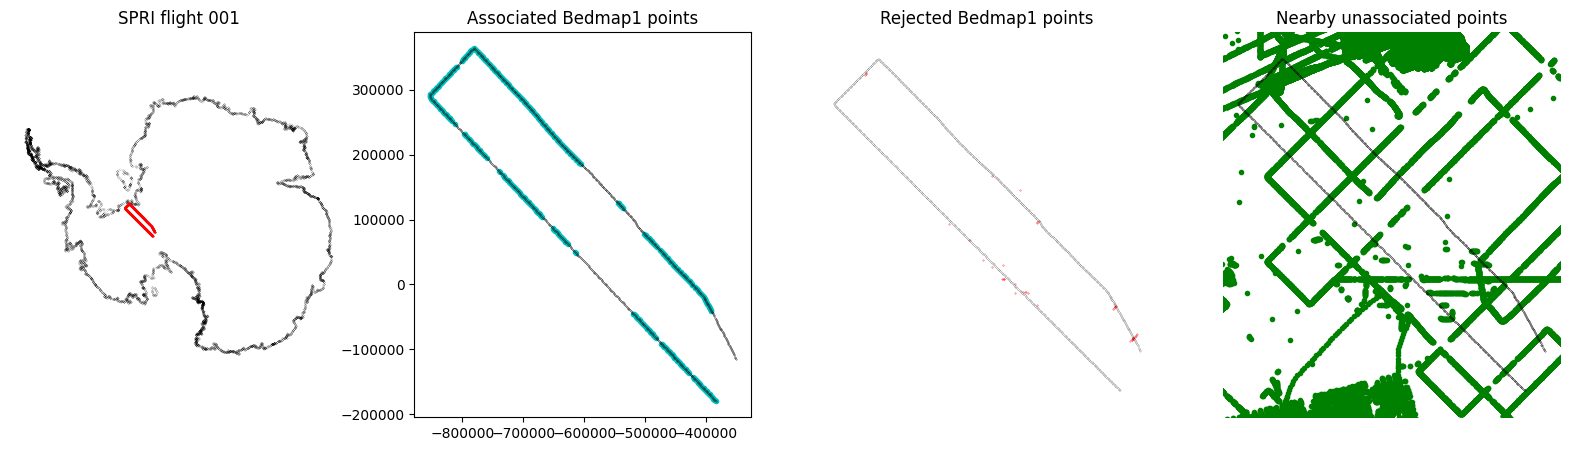

invalid label nn for flight 008 seg 18323-18324


In [432]:
ncols = 3
nrows = len(spri_xx.keys())

fig = plt.figure(figsize=(20, 5))
ax1, ax2, ax3, ax4 = fig.subplots(1,4)
ax1.plot(gl_xx, gl_yy, 'k.', markersize=0.1)
ax4.plot(bm1_xx[remaining_idxs], bm1_yy[remaining_idxs], 'g.')


ax1_spri = None
ax2_bm = None
ax2_spri = None
ax3_bm = None
ax3_spri = None
ax4_spri = None


for _, flight in enumerate(spri_xx.keys()):
#for flight in ['143']:
    xx = spri_xx[flight]
    yy = spri_yy[flight]
    for ax in [ax1, ax3, ax4]:
        ax.axis('equal')
        ax.axis('off')
        
    # Plot context for this flight, w/r/t the entire continent
    if ax1_spri is None:
        ax1_spri, = ax1.plot(xx, yy, 'r.', markersize=0.5)
    else:
        ax1_spri.set_xdata(xx)
        ax1_spri.set_ydata(yy)
    ax1.set_title("SPRI flight {}".format(flight))
    

    seg_idxs = []
    rejected_idxs = []
    for (s0, s1), label in human_labels[flight].items():
        idxs = np.arange(s0, s1+1)
        if label == 'y' or label == 'x':
            seg_idxs.extend(idxs)
        elif label == 'n' or label == 'nx':
            rejected_idxs.extend(idxs)
        else:
            print("invalid label {} for flight {} seg {}-{}".format(label, flight, s0, s1))

    if ax2_bm is None:
        ax2_bm, = ax2.plot(bm1_xx[seg_idxs], bm1_yy[seg_idxs], 'c.')
    else:
        ax2_bm.set_xdata(bm1_xx[seg_idxs])
        ax2_bm.set_ydata(bm1_yy[seg_idxs])
    if ax2_spri is None:
        ax2_spri, = ax2.plot(spri_xx[flight], spri_yy[flight], 'k.', markersize=0.5)
    else:
        ax2_spri.set_xdata(spri_xx[flight])
        ax2_spri.set_ydata(spri_yy[flight])
    ax2.set_title("Associated Bedmap1 points")
    
    # Plot points that were rejected
    if ax3_bm is None:
        ax3_bm, = ax3.plot(bm1_xx[rejected_idxs], bm1_yy[rejected_idxs], 'r.', markersize=0.5)
    else:
        ax3_bm.set_xdata(bm1_xx[rejected_idxs])
        ax3_bm.set_ydata(bm1_yy[rejected_idxs])
    if ax3_spri is None:
        ax3_spri, = ax3.plot(spri_xx[flight], spri_yy[flight], 'k.', markersize=0.2)
        pass
    else:
        ax3_spri.set_xdata(spri_xx[flight])
        ax3_spri.set_ydata(spri_yy[flight])
        pass
    ax3.set_title("Rejected Bedmap1 points")

    # Plot bedmap points without any corresponding SPRI line
    if ax4_spri is None:
        ax4_spri, = ax4.plot(spri_xx[flight], spri_yy[flight], 'k.', markersize=0.5)
    else:
        ax4_spri.set_xdata(spri_xx[flight])
        ax4_spri.set_ydata(spri_yy[flight])
    ax4.set_title("Nearby unassociated points")
    
    # Adjust bounds to frame just the flight
    border = 25000
    xmin = np.min(spri_xx[flight]) - border
    xmax = np.max(spri_xx[flight]) + border
    ymin = np.min(spri_yy[flight]) - border
    ymax = np.max(spri_yy[flight]) + border
    for ax in [ax2, ax4]:
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])


    
    plt.show()
    fig.savefig("SPRI_flights/labels_flight{}.png".format(flight))


### Is there any organization to the points within the overall bedmap dataset?

Labeled 455 segments; after concatenating, have 105


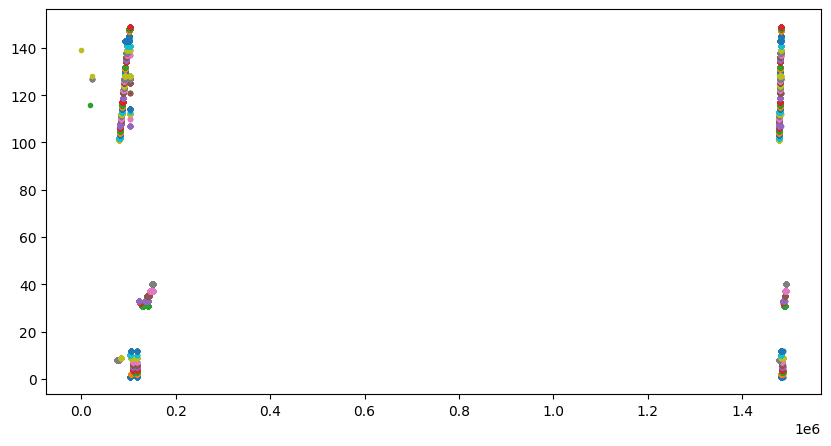

In [400]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1,1)
print("Labeled {} segments; after concatenating, have {}".format(num_segments, len(bm1_segments)))

In [401]:
len(spri_idxs)

68925

In [402]:
# How big are the gaps between segments? Are there any that we missed?
segment_gaps = []
for idx in np.arange(1, len(bm1_segments)):
    segment_gaps.append(bm1_segments[idx][0] - bm1_segments[idx-1][1]-1)

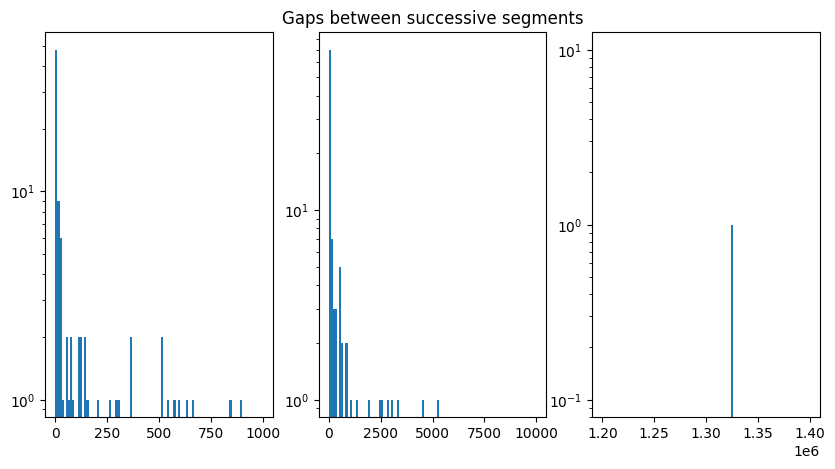

In [403]:
fig = plt.figure(figsize=(10,5))
ax1, ax2, ax3 = fig.subplots(1,3)

ax1.hist(segment_gaps, bins=100, range=(0, 1e3))
ax1.set_yscale('log')

ax2.hist(segment_gaps, bins=100, range=(0, 1e4))
ax2.set_title("Gaps between successive segments")
ax2.set_yscale('log')
    
    
ax3.hist(segment_gaps, bins=100, range=(1.2e6, 1.4e6))
ax3.set_yscale('log')

It looks like there are a lot of single-point outliers, but also a solid handful that are larger.
Additionally, for the single-point outliers, flight 31 had a bunch that were hundreds of kilometers away.

In [110]:
from typing import Dict
def plot_flight_segments(flight, 
                         bm1_idxs: Dict[str, np.ndarray], 
                         bm1_xx: np.ndarray, 
                         bm1_yy: np.ndarray, 
                         inst_xx: Dict[str, np.ndarray], 
                         inst_yy: Dict[str, np.ndarray]
                        ):
    

    flight_idxs = list(set(spri_bm1_idxs[flight]))
    flight_idxs.sort()
    flight_segments = segment_indices(flight_idxs, 1, 5)  # Grab them ALL for now
    print(len(flight_segments))

    ncols = 3
    nrows = int(np.ceil(len(flight_segments) / ncols))

    fig = plt.figure(figsize=(3*ncols, 3*nrows))
    axes = fig.subplots(nrows, ncols)

    extend = 0  # How many *points* to extend the segment in order to 
    for ax_idx, (s0, s1) in enumerate(flight_segments):
        min_idx = max(0, s0-extend)
        max_idx = min(s1+extend, len(bm1_xx))
        idxs = np.arange(min_idx, max_idx+1)
        row = int(np.floor(ax_idx / ncols))
        col = ax_idx % ncols
        if nrows > 1:
            ax = axes[row][col]
        else:
            ax = axes[col]
        ax.axis('equal')
        ax.axis('off')
        xx = bm1_xx[idxs]
        yy = bm1_yy[idxs]
        ax.scatter(xx, yy, c=idxs, edgecolors=None)
        ax.plot(inst_xx[flight], inst_yy[flight], 'k.', markersize=0.5)
        ax.set_title("{}-{}".format(s0, s1))
        border = 10000 
        ax.set_xlim((np.min(xx)-border, np.max(xx)+border))
        ax.set_ylim((np.min(yy)-border, np.max(yy)+border))
    
    fig.savefig("SPRI_flights/Flight{}.png".format(flight))

In [ ]:
for flight in spri_xx.keys():
    plot_flight_segments(flight, spri_bm1_idxs, bm1_xx, bm1_yy, spri_xx, spri_yy)

### Can we filter based on dist = 0.0 km?

A lot of the points found by 'find_closest_bedmap' have distance 0 from the corresponding point in the Stanford/SPRI dataset. 

Can we simply use that as the metric, and look at all of the bedmap points?


Text(0, 0.5, 'Distance (m)')

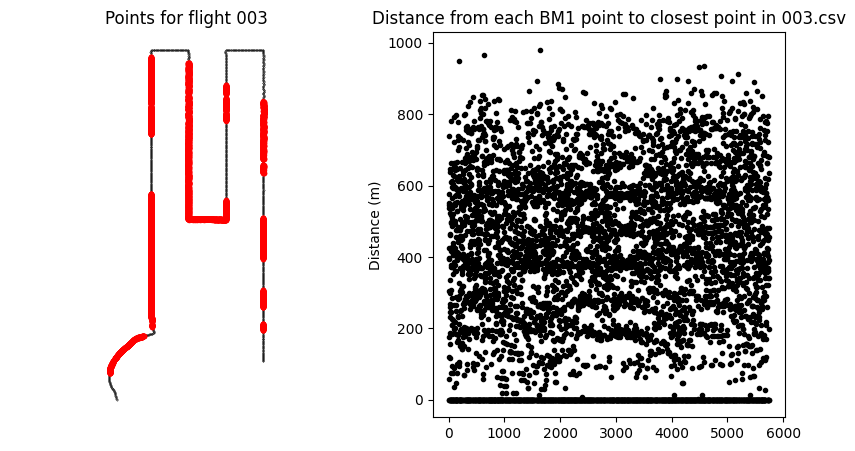

In [91]:
flight = '003'

good_idxs = set()
for (s0, s1), ll in human_labels[flight].items():
    if ll == 'y':
        good_idxs.update(np.arange(s0,s1+1))


dists = [np.inf for _ in good_idxs]
for idx, ii in enumerate(good_idxs):
    dx = spri_xx[flight]-bm1_xx[ii]
    dy = spri_yy[flight]-bm1_yy[ii]
    dists[idx] = np.min(np.sqrt(dx*dx + dy*dy))
dists
        
fig = plt.figure(figsize=(10,5))
ax, ax2 = fig.subplots(1,2)
ax.axis('equal')
ax.axis('off')
ax.plot(spri_xx[flight], spri_yy[flight], 'k.', markersize=0.5)
ax.plot(bm1_xx[list(good_idxs)], bm1_yy[list(good_idxs)], 'r.') 
ax.set_title("Points for flight {}".format(flight))

ax2.plot(dists, 'k.')
ax2.set_title("Distance from each BM1 point to closest point in {}.csv".format(flight))
ax2.set_ylabel("Distance (m)")

Nope! For some flights (e.g. 004), ALL the points are dist 0, while for others, (e.g. 003), they vary by a few hundred meters.

### Debugging Flight 35

Flight 35 is a problem -- there are stretches that aren't ever represented in the "closest" bedmap indices.
Try getting ALL nearby ones and then classifying.

Turns out, there was a bug in my plotting code that generated the figures!

In [ ]:
def find_nearby_bedmap(survey_xx, survey_yy, bm1_xx, bm1_yy, decimation=None, subsampling=None, radius=5000):
    """
    For every point in the input survey, find all nearby points in BM1.
    For computational reasons, it is usually best to subsample/decimate the input data
    * subsampling: distance (in meters) between output subsampled points
    * decimation: only keep the N-th input point
    
    This can backfire if nearby surveys are ordered sequentially, leading
    to the "expanded" segment including a neighboring line.
    """
    if subsampling is not None:
        xx, yy = subsample_tracks_uniform(survey_xx, survey_yy, subsampling)
        print("Subsampled {} -> {}".format(len(survey_xx), len(xx)))
    elif decimation is not None:
        survey_idxs = np.arange(0, len(survey_xx), decimation)
        survey_idxs = np.append(survey_idxs, len(survey_xx) - 1)
        xx = survey_xx[survey_idxs]
        yy = survey_yy[survey_idxs]
    else:
        print("WARNING: attempting to find closest bedmap points at full resolution!")
        xx = survey_xx
        yy = survey_yy

    min_bm1_idxs = []

    for idx in np.arange(len(xx)):
        dx = np.abs(bm1_xx - xx[idx])
        dy = np.abs(bm1_yy - yy[idx])
        dists = np.sqrt(dx*dx + dy*dy)
        nearby_idxs, = np.where(dists < radius)
        min_bm1_idxs.extend(nearby_idxs)
    # Need array of ints to use as indices
    min_bm1_idxs = list(set([int(el) for el in min_bm1_idxs]))
    return np.array(min_bm1_idxs)

In [ ]:
closest = find_closest_bedmap(spri_xx['035'], spri_yy['035'], bm1_xx, bm1_yy)
nearby = find_nearby_bedmap(spri_xx['035'], spri_yy['035'], bm1_xx, bm1_yy)

In [ ]:
print("{} closest points, and {} nearby".format(len(closest), len(nearby)))

5109 closest points, and 124940 nearby


Text(0.5, 1.0, "bedmap points that aren't nearby")

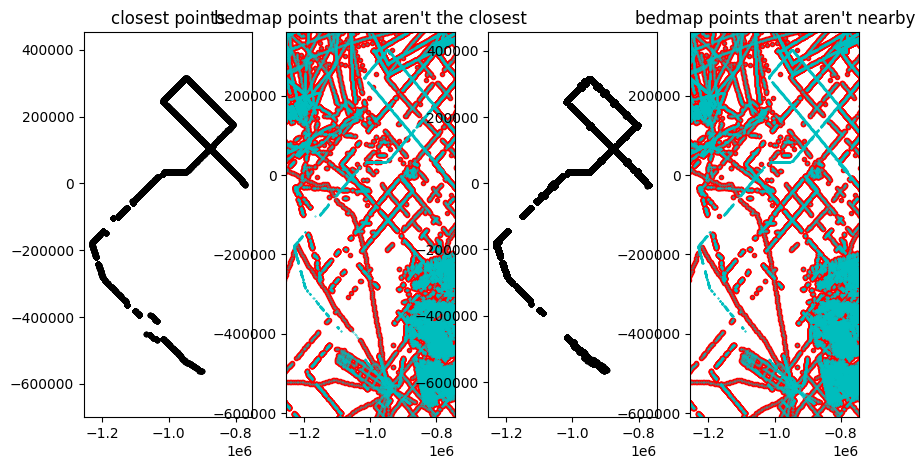

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2, ax3, ax4 = fig.subplots(1, 4)


not_closest_idxs = np.setdiff1d(np.arange(0, len(bm1_xx)), closest)
not_nearby_idxs = np.setdiff1d(np.arange(0, len(bm1_xx)), nearby)

ax1.plot(bm1_xx[closest], bm1_yy[closest], 'k.')
ax1.set_title('closest points')
ax3.plot(bm1_xx[nearby], bm1_yy[nearby], 'k.')
ax1.axis('equal')
ax3.axis('equal')
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()

ax2.plot(bm1_xx[not_closest_idxs], bm1_yy[not_closest_idxs], 'r.')
ax2.plot(bm1_xx, bm1_yy, 'c.', markersize=0.7)
#ax2.plot(spri_xx['035'], spri_yy['035'], 'k.', markersize=0.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title("bedmap points that aren't the closest")

ax4.plot(bm1_xx[not_nearby_idxs], bm1_yy[not_nearby_idxs], 'r.')
ax4.plot(bm1_xx, bm1_yy, 'c.', markersize=0.7)
#ax4.plot(spri_xx['035'], spri_yy['035'], 'k.', markersize=0.5)
ax4.set_xlim(xlim)
ax4.set_ylim(ylim)
ax4.set_title("bedmap points that aren't nearby")

The above plots show that we ARE finding the points, so it's somewhere downstream that is losing them.

In [294]:
closest = list(set(closest))
max_step = 1
min_length = 1
max_gap = 25000
segments = segment_indices_gap(closest, max_step, min_length, bm1_xx, bm1_yy, max_gap)

In [299]:
segment_idxs = []
for s0,s1 in segments:
    segment_idxs.extend(np.arange(s0, s1+1))
not_segment_idxs = np.setdiff1d(np.arange(0, len(bm1_xx)), segment_idxs)

In [296]:
print("from {} unique indices, we have {} segments and {} in-range points".format(len(closest), len(segments), len(segment_idxs)))

from 3556 unique indices, we have 111 segments and 3556 in-range points


Text(0.5, 1.0, "bedmap points that aren't in the list of segment indices")

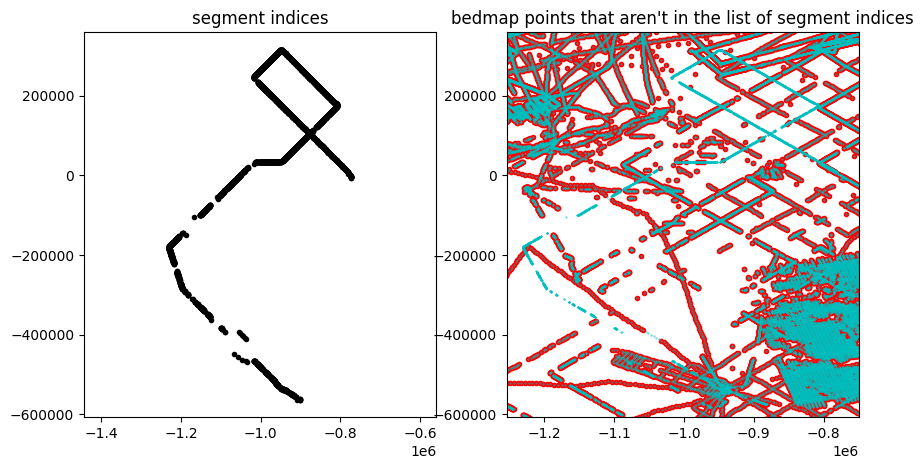

In [301]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.plot(bm1_xx[segment_idxs], bm1_yy[segment_idxs], 'k.')
ax1.set_title('segment indices')
ax1.axis('equal')
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()

ax2.plot(bm1_xx[not_segment_idxs], bm1_yy[not_segment_idxs], 'r.')
ax2.plot(bm1_xx, bm1_yy, 'c.', markersize=0.7)
#ax2.plot(spri_xx['035'], spri_yy['035'], 'k.', markersize=0.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title("bedmap points that aren't in the list of segment indices")



In [315]:
# OK, so then some of the labels must be wrong. 
# We've established that the points ARE in the segments....
y_idxs = []
n_idxs = []
for segment in segments:
    s0, s1 = segment
    if segment in human_labels['035']:
        label = human_labels['035'][segment]
    else:
        contained = False
        for (l0, l1), ll in human_labels['035'].items():
            if s0 >= l0 and s1 <= l1:
                contained = True
                label = ll
                break
        if not contained:
            print("missing {}".format(segment))
            continue
    seg_idxs = np.arange(s0, s1+1)
    if label in ['n', 'nx']:
        n_idxs.extend(seg_idxs)
    elif label in ['y', 'x']:
        y_idxs.extend(seg_idxs)

In [317]:
# Check that we haven't lost any points ...
print("for {} total points, {} are Y and {} are N".format(len(segment_idxs), len(y_idxs), len(n_idxs)))

for 3556 total points, 3506 are Y and 50 are N


Text(0.5, 1.0, 'bedmap points that are on the flight')

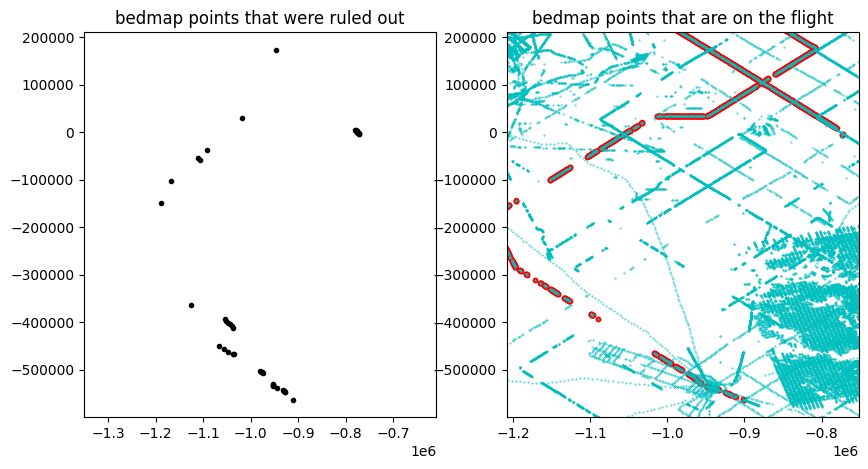

In [406]:
fig = plt.figure(figsize=(10, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.plot(bm1_xx[n_idxs], bm1_yy[n_idxs], 'k.')
ax1.set_title('bedmap points that were ruled out')
ax1.axis('equal')
xlim = ax1.get_xlim()
ylim = ax1.get_ylim()

ax2.plot(bm1_xx[y_idxs], bm1_yy[y_idxs], 'r.')
ax2.plot(bm1_xx, bm1_yy, 'c.', markersize=0.7)
#ax2.plot(spri_xx['035'], spri_yy['035'], 'k.', markersize=0.5)
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_title("bedmap points that are on the flight")

